In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import Tensor
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import ResNet50, MobileNetV2

import os
import splitfolders
import glob
import pickle

import warnings
warnings.filterwarnings('ignore')

2025-09-07 13:36:41.234242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FILE_PATH = './img'

In [6]:
if not os.path.exists('./output'):


    splitfolders.ratio(FILE_PATH, output = 'output', seed = 42, ratio = (0.8, 0.1, 0.1))

    
else:
    print("Directorios ya creados")

train_path = './output/train'
test_path = './output/test'
val_path = './output/val'
class_name = os.listdir(train_path)
class_test = os.listdir(test_path)
class_val = os.listdir(val_path)


Directorios ya creados


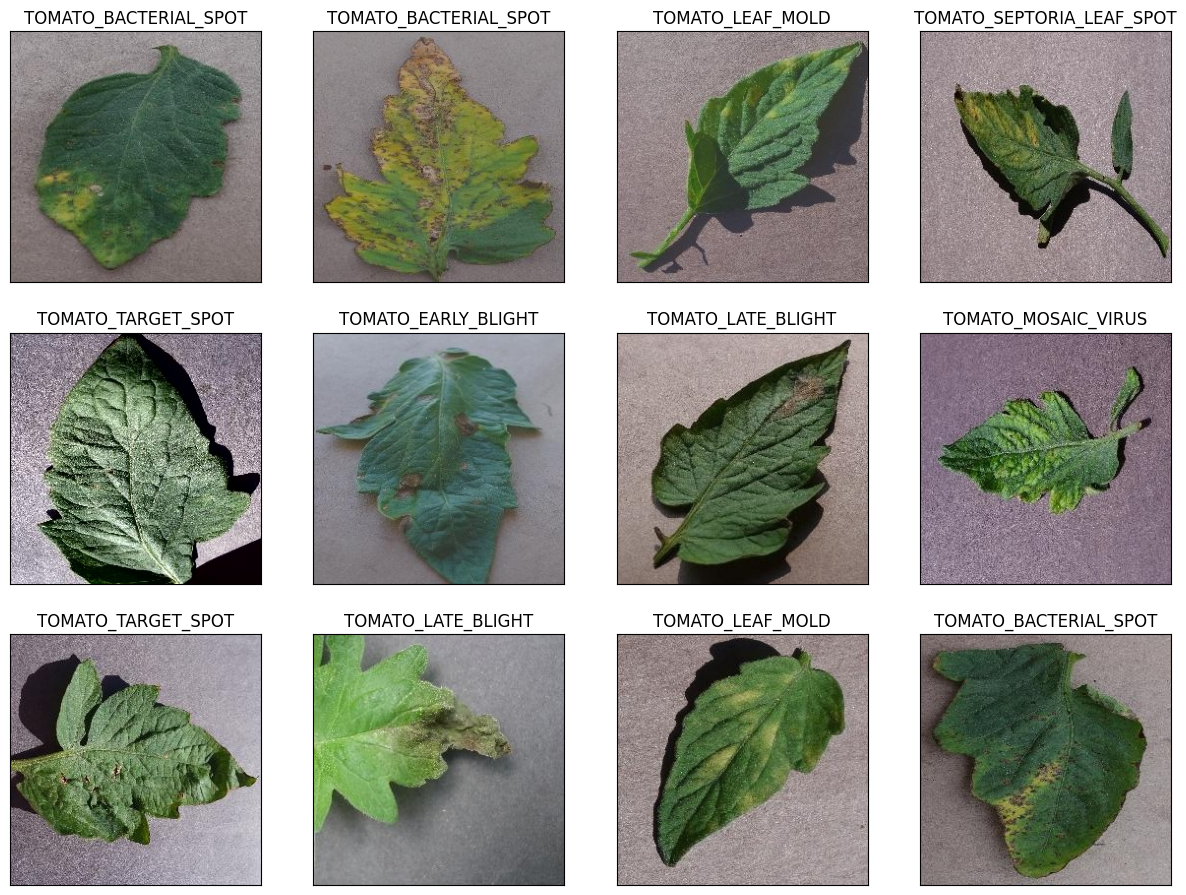

In [4]:
total_train_images = glob.glob('./output/train/*/*.jpg')
train_df = pd.DataFrame(pd.Series(total_train_images))

train_df['Filename'] = train_df[0].apply(lambda x: x.split('/')[-1])
train_df['class'] = train_df[0].apply(lambda x: x.split('/')[-2])

plot_df = train_df.sample(12).reset_index()

plt.figure(figsize = (15,15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    class_str = plot_df.loc[i, 'class']
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(FILE_PATH, class_str, img_name)))
    plt.title(class_str)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
# train_datagen = ImageDataGenerator(zoom_range= 0.15, width_shift_range= 0.2, height_shift_range= 0.2, shear_range= 0.10)
# test_datagen = ImageDataGenerator()
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow_from_directory(
#     train_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = True
# )

# test_generator = test_datagen.flow_from_directory(
#     test_path, target_size = (256, 256),
#     batch_size = 32,
#     shuffle = False
# )

# val_generator = val_datagen.flow_from_directory(
#     val_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = False
# )

In [7]:
train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    test_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    val_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

Found 165679 files belonging to 8 classes.


I0000 00:00:1757263377.739596    1033 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


Found 20718 files belonging to 8 classes.
Found 20707 files belonging to 8 classes.


# ResNet50

In [8]:
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

In [11]:
# for layer in base_model.layers:
#     layer.trainable = False

In [12]:
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation = 'relu')(x)
# predictions = Dense(8, activation = 'softmax')(x)

# model = Model(inputs = base_model.input, outputs = predictions)

In [9]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_rn50 = Model(inputs, outputs)

In [10]:
model_rn50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      2,056 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
model_rn50.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [12]:
history_rn50 = model_rn50.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-07 13:44:03.248660: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e0c80049240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-07 13:44:03.248721: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-07 13:44:03.610741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-07 13:44:05.161364: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-07 13:44:05.407516: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-07 13:44:06.170736: I e

5178/5178 ━━━━━━━━━━━━━━━━━━━━ 427s 80ms/step - accuracy: 0.8906 - loss: 0.3489 - val_accuracy: 0.9620 - val_loss: 0.1148
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 409s 79ms/step - accuracy: 0.9315 - loss: 0.1978 - val_accuracy: 0.9655 - val_loss: 0.0969
Epoch 3/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 387s 75ms/step - accuracy: 0.9398 - loss: 0.1732 - val_accuracy: 0.9684 - val_loss: 0.0901
Epoch 4/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 387s 75ms/step - accuracy: 0.9452 - loss: 0.1605 - val_accuracy: 0.9787 - val_loss: 0.0648
Epoch 5/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 385s 74ms/step - accuracy: 0.9484 - loss: 0.1517 - val_accuracy: 0.9805 - val_loss: 0.0573
Epoch 6/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 385s 74ms/step - accuracy: 0.9503 - loss: 0.1463 - val_accuracy: 0.9717 - val_loss: 0.0827
Epoch 7/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 396s 77ms/step - accuracy: 0.9520 - loss: 0.1419 - val_accuracy: 0.9780 - val_loss: 0.0677
Epoch 8/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 397s 77ms/step - accuracy: 0.9536 - lo

# MobileNet V2

In [13]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

In [14]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_mnv2 = Model(inputs, outputs)

In [15]:
model_mnv2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
model_mnv2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
history_mnv2 = model_mnv2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-07 14:50:25.479577: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-07 14:50:26.979260: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4682', 520 bytes spill stores, 520 bytes spill loads



5178/5178 ━━━━━━━━━━━━━━━━━━━━ 210s 36ms/step - accuracy: 0.8023 - loss: 0.5730 - val_accuracy: 0.8967 - val_loss: 0.2964
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 153s 29ms/step - accuracy: 0.8567 - loss: 0.4057 - val_accuracy: 0.9139 - val_loss: 0.2497
Epoch 3/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 154s 30ms/step - accuracy: 0.8690 - loss: 0.3696 - val_accuracy: 0.9186 - val_loss: 0.2373
Epoch 4/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 164s 32ms/step - accuracy: 0.8778 - loss: 0.3467 - val_accuracy: 0.9226 - val_loss: 0.2222
Epoch 5/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 162s 31ms/step - accuracy: 0.8825 - loss: 0.3356 - val_accuracy: 0.9263 - val_loss: 0.2133
Epoch 6/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 152s 29ms/step - accuracy: 0.8870 - loss: 0.3224 - val_accuracy: 0.9226 - val_loss: 0.2225
Epoch 7/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8903 - loss: 0.3144 - val_accuracy: 0.9289 - val_loss: 0.2000
Epoch 8/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - accuracy: 0.8916 - lo

# Gráfica de comparación

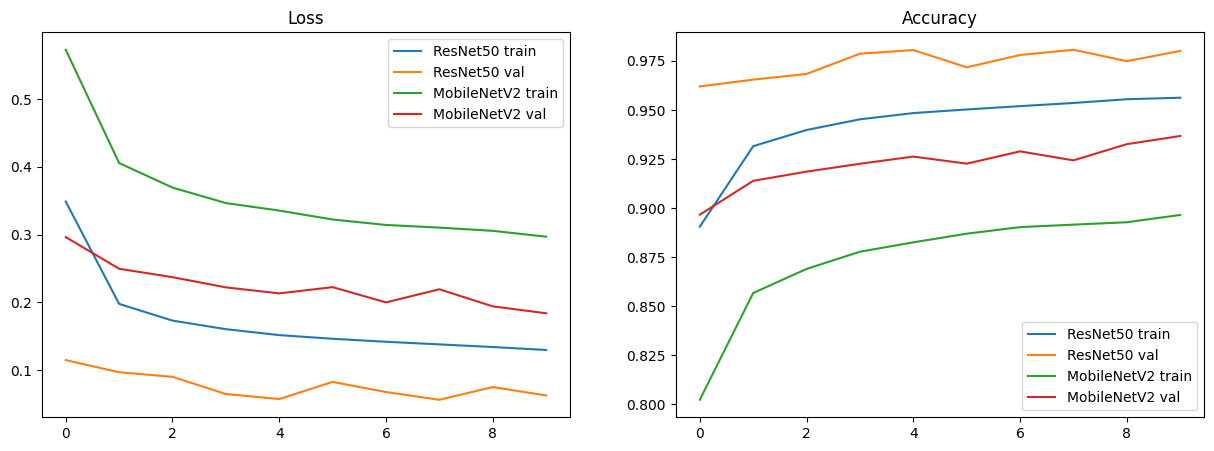

In [18]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1);plt.plot(history_rn50.history['loss'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_loss'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['loss'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_loss'], label = 'MobileNetV2 val');
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2);plt.plot(history_rn50.history['accuracy'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_accuracy'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['accuracy'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_accuracy'], label = 'MobileNetV2 val');
plt.legend()
plt.title('Accuracy')
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def report(data_ds, class_names = None, model = None, verbose = 0) -> None:

    if model is None:
        try:
            _:model.summary
        except NameError:
            raise ValueError("Debería pasa 'model' explícitamente")

    y_true = []
    y_pred = []

    for batch_x, batch_y in data_ds:
        preds = model.predict(batch_x)
        y_pred.extend(np.argmax(preds, axis = 1))

        by = batch_y.numpy()
        if by.ndim == 2:
            y_true.extend(np.argmax(by, axis = 1))
        else:
            y_true.extend(by.astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        n_classes = int(max(y_true.max(), y_pred.max()) + 1)
        class_names = [f"class_{i}" for i in range(n_classes)]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


2025-09-07 15:18:24.715293: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


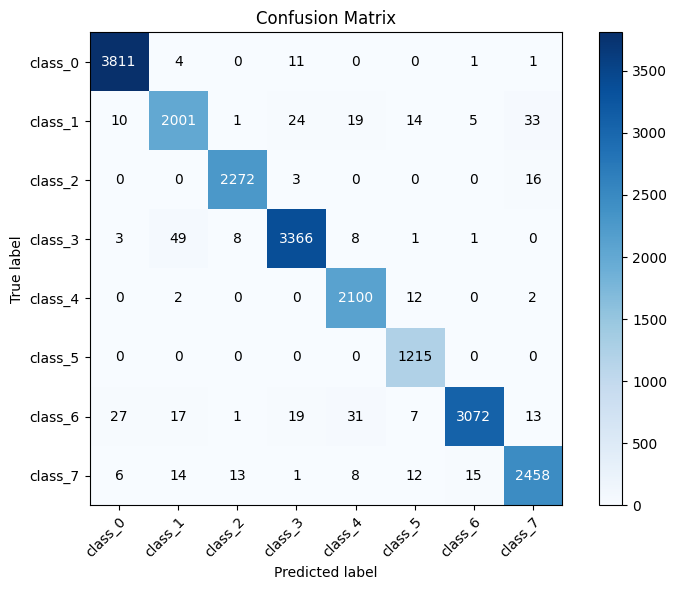

In [20]:
report(val_ds, model = model_rn50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

2025-09-07 15:19:31.662179: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


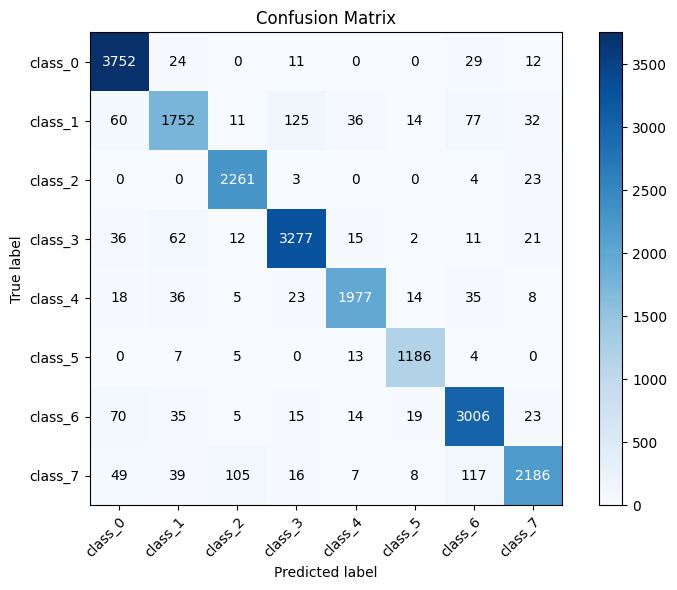

In [21]:
report(val_ds, model = model_mnv2)

In [22]:
for images, labels in test_ds.take(1):
    print(f"Batch size: {images.shape}")
    print(f"Labels: {labels}")

    preds = model_rn50.predict(images)
    pred_classes = preds.argmax(axis = 1)

Batch size: (32, 256, 256, 3)
Labels: [[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

def predict_single(model, dataset, class_names=None, index=None, verbose=0):

    for img, labs in dataset.take(1):
        batch_size = img.shape[0]

    if index is None:
        # Get the total number of samples in the dataset
        num_samples = tf.data.experimental.cardinality(dataset).numpy() * dataset.element_spec[0].shape[0]
        index = random.randint(0, num_samples - 1)

    # Find the batch and index within the batch for the selected sample
    batch_index = index // batch_size
    sample_index_in_batch = index % batch_size

    # Get the specific batch
    for i, (imgs, labs) in enumerate(dataset):
        if i == batch_index:
            img = imgs[sample_index_in_batch]
            label = labs[sample_index_in_batch]
            break

    # Model expects a batch
    img_batch = tf.expand_dims(img, axis=0)

    preds = model.predict(img_batch, verbose=verbose)
    pred_class_idx = np.argmax(preds, axis=1)[0]

    # True label index
    if label.ndim > 0 and label.shape[-1] > 1:   # one-hot vector
        true_idx = np.argmax(label.numpy())
    else:
        true_idx = int(label.numpy())

    # Show the image
    plt.imshow(img.numpy().astype("uint8"))
    if class_names:
        plt.title(f"True: {class_names[true_idx]} | Pred: {class_names[pred_class_idx]}")
    else:
        plt.title(f"True idx: {true_idx} | Pred idx: {pred_class_idx}")
    plt.axis("off")
    plt.show()

    if class_names:
        print(f"True label: {class_names[true_idx]} (index {true_idx})")
        print(f"Predicted : {class_names[pred_class_idx]} (index {pred_class_idx})")
    else:
        print(f"True label index: {true_idx}")
        print(f"Predicted index : {pred_class_idx}")

2025-09-07 15:19:32.672011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


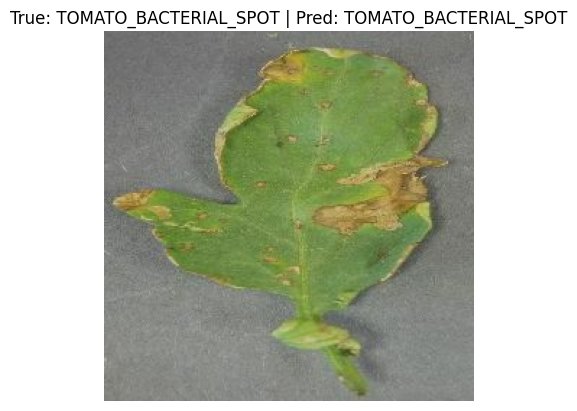

True label: TOMATO_BACTERIAL_SPOT (index 0)
Predicted : TOMATO_BACTERIAL_SPOT (index 0)


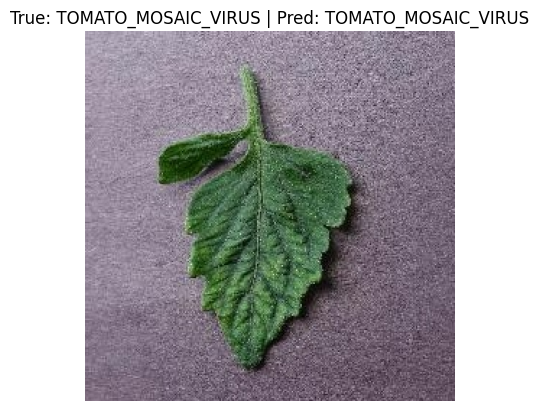

True label: TOMATO_MOSAIC_VIRUS (index 5)
Predicted : TOMATO_MOSAIC_VIRUS (index 5)


In [24]:
# assuming you already created test_ds and stored class_names before prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_rn50, test_ds, class_names, index=5)
predict_single(model_rn50, test_ds, class_names, index=15000)


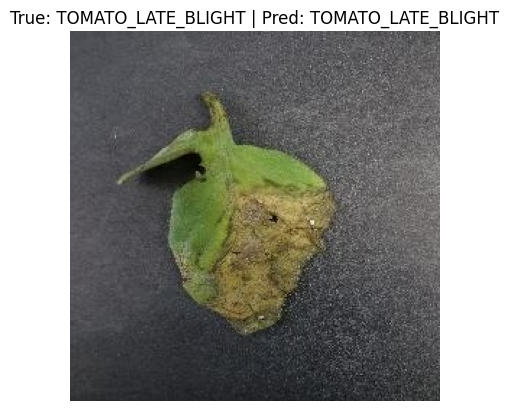

True label: TOMATO_LATE_BLIGHT (index 3)
Predicted : TOMATO_LATE_BLIGHT (index 3)


In [25]:
# assuming you already created test_ds and stored class_n
#prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_mnv2, test_ds, class_names, index = 10000)

In [29]:
model_rn50.save('model_rn50.keras')

In [30]:
model_mnv2.save('model_mnv2.keras')

In [31]:
import json

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)